<a href="https://colab.research.google.com/github/Michel-p16/PDS-Project/blob/Michel/TinyLlama_Single_Select_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ✅ Setup für Google Colab: Installiere notwendige Bibliotheken
!pip install -q transformers datasets accelerate bitsandbytes peft torch torchvision torchaudio scikit-learn matplotlib

import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [4]:
# ✅ 1. Modellwahl (TinyLLaMa oder LLaMa-2)
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # Alternativ: "meta-llama/Llama-2-7b-chat-hf"

# ✅ 2. Lade Tokenizer und Modell mit LoRA (Low-Rank Adaptation)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=58, device_map="auto")

# ✅ Padding-Token definieren (LLaMa hat standardmäßig keinen pad_token)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id


lora_config = LoraConfig(
    r=8, lora_alpha=32, target_modules=["q_proj", "v_proj"],  # Zielmodule für LoRA
    lora_dropout=0.05, bias="none", task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,245,184 || all params: 1,035,876,352 || trainable%: 0.1202


In [6]:
# ✅ 3. Daten laden und vorbereiten
with open("/content/final_single_question_data.json", "r") as f:
    raw_data = json.load(f)

# ✅ 4. Daten in das richtige Format umwandeln
def preprocess_data(data):
    processed_data = []
    label_map = {}  # Label-Index-Zuordnung
    label_id = 0

    for item in data:
        question = item["question"]
        for answer in item["answers"]:
            answer_text = answer["answer_text"]
            label = answer["answer_label"]

            # Erstellt ein Mapping von Label-Texten zu numerischen IDs
            if label not in label_map:
                label_map[label] = label_id
                label_id += 1

            processed_data.append({
                "text": f"Question: {question} Answer: {answer_text}",
                "label": label_map[label]
            })

    return processed_data, label_map

dataset, label_map = preprocess_data(raw_data)
num_labels = len(label_map)  # Anzahl der Labels = 58

# ✅ 5. Konvertiere in Hugging Face Dataset
dataset_hf = Dataset.from_list(dataset).train_test_split(test_size=0.1)

In [7]:
# ✅ 6. Tokenisierung der Daten
def tokenize_data(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

dataset_hf = dataset_hf.map(tokenize_data, batched=True)
dataset_hf = dataset_hf.rename_column("label", "labels")  # Benenne um für Hugging Face Trainer
dataset_hf.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/6237 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

In [8]:
# ✅ 7. Trainingsargumente definieren
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
)

# ✅ 8. Trainer einrichten
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_hf["train"],
    eval_dataset=dataset_hf["test"],
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [9]:
# ✅ 9. Starte das Training
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.095100,0.088916


TrainOutput(global_step=3119, training_loss=0.5839913344681359, metrics={'train_runtime': 2043.0747, 'train_samples_per_second': 3.053, 'train_steps_per_second': 1.527, 'total_flos': 9295891623051264.0, 'train_loss': 0.5839913344681359, 'epoch': 1.0})

In [10]:
# ✅ 10. Speichere das Modell
trainer.save_model("./fine_tuned_tiny_llama")

In [11]:
# ✅ 11. Evaluierung des Modells
predictions = trainer.predict(dataset_hf["test"])
preds = np.argmax(predictions.predictions, axis=1)
labels = dataset_hf["test"]["labels"]

# Klassifikationsreport anzeigen
print("Classification Report:")
print(classification_report(labels, preds, target_names=label_map.keys()))

Classification Report:
                                    precision    recall  f1-score   support

                      New customer       1.00      0.93      0.96        14
                 Existing customer       0.92      1.00      0.96        12
                           Partner       1.00      1.00      1.00        11
                         Applicant       1.00      1.00      1.00        11
                    Very satisfied       0.72      1.00      0.84        13
                         Satisfied       1.00      0.38      0.55         8
                       Unsatisfied       1.00      0.71      0.83         7
                  Very unsatisfied       0.89      1.00      0.94        17
                               1-5       1.00      1.00      1.00         9
                              6-10       1.00      1.00      1.00        10
                             11-15       1.00      1.00      1.00        13
                             16-20       1.00      1.00      1.0

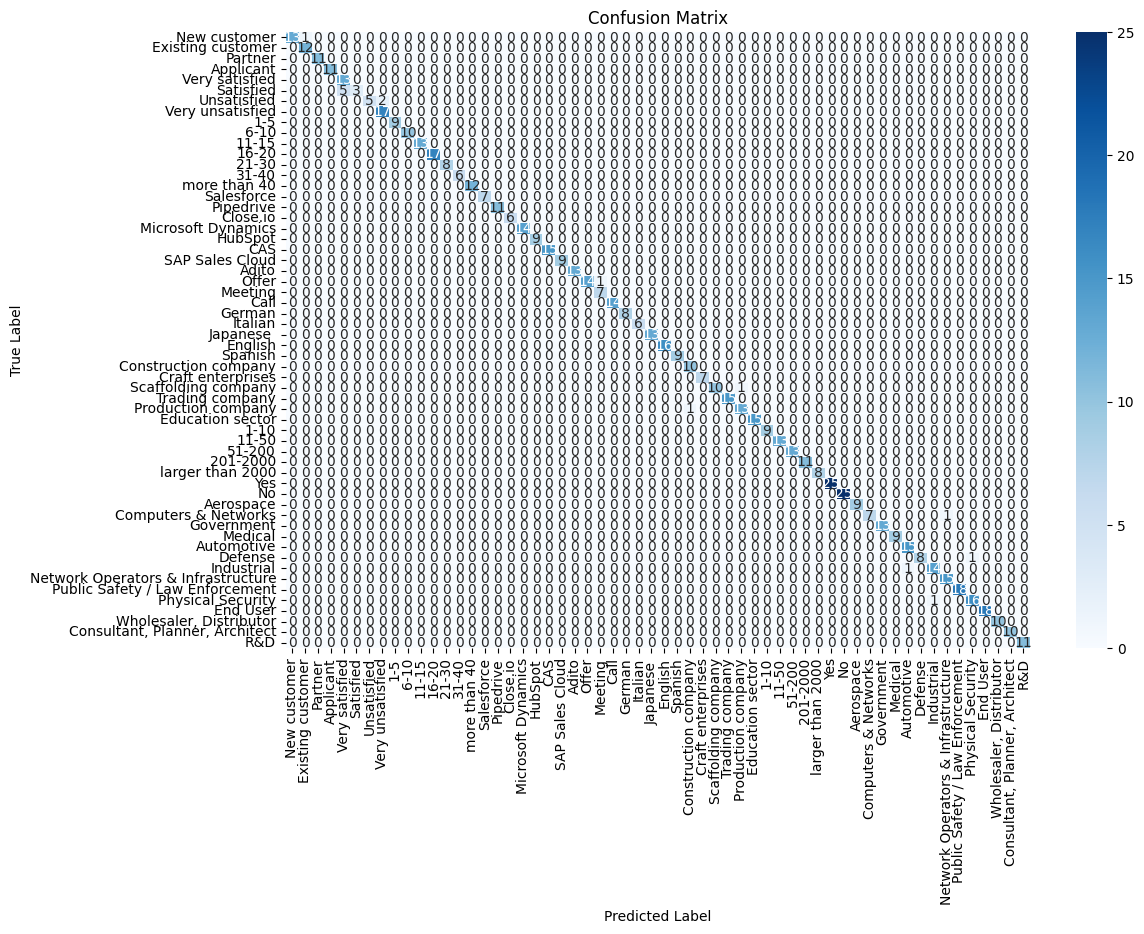

In [12]:
# ✅ 12. Konfusionsmatrix plotten
plt.figure(figsize=(12, 8))
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [15]:
def predict(model, tokenizer, label_map, examples):
    """
    Führt Vorhersagen mit dem trainierten Modell für gegebene Frage-Antwort-Paare durch.

    Args:
    - model: Das trainierte Hugging Face Modell
    - tokenizer: Tokenizer, um den Text vorzubereiten
    - label_map: Dictionary mit Label-Index-Zuordnung
    - examples: Liste mit Frage-Antwort-Kombinationen (Strings)

    Returns:
    - Gibt die Vorhersagen für jede Eingabe aus
    """
    model.eval()  # Setzt das Modell in den Evaluationsmodus

    label_map_inv = {v: k for k, v in label_map.items()}  # Label-ID → Label-Text

    inputs = tokenizer(examples, padding=True, truncation=True, max_length=256, return_tensors="pt")

    # Falls GPU genutzt wird, Eingabe auch auf die GPU verschieben
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():  # Kein Gradient-Tracking für Vorhersagen
        outputs = model(**inputs)

    logits = outputs.logits  # Rohe Vorhersage-Werte
    probs = torch.nn.functional.softmax(logits, dim=-1)  # Wahrscheinlichkeiten berechnen
    preds = torch.argmax(probs, dim=-1).cpu().numpy()  # Höchstwahrscheinliche Klasse

    # Ergebnisse anzeigen
    for i, example in enumerate(examples):
        label = label_map_inv[preds[i]]
        confidence = probs[i][preds[i]].item()
        print(f"\n🔹 Eingabe: {example}")
        print(f"✅ Vorhergesagtes Label: {label} (Confidence: {confidence:.2f})")



In [16]:
# Beispieldaten
test_examples = [
    "Question: What type of customer are you? Answer: I'm a first-time buyer exploring your offerings.",
    "Question: How often do you use our service? Answer: I have been a loyal customer for over 5 years.",
    "Question: What is your feedback? Answer: The product quality is amazing, but the delivery was slow.",
]

# Vorhersage ausführen
predict(model, tokenizer, label_map, test_examples)


🔹 Eingabe: Question: What type of customer are you? Answer: I'm a first-time buyer exploring your offerings.
✅ Vorhergesagtes Label: New customer (Confidence: 1.00)

🔹 Eingabe: Question: How often do you use our service? Answer: I have been a loyal customer for over 5 years.
✅ Vorhergesagtes Label: Very satisfied (Confidence: 0.55)

🔹 Eingabe: Question: What is your feedback? Answer: The product quality is amazing, but the delivery was slow.
✅ Vorhergesagtes Label: Unsatisfied (Confidence: 0.84)
